In [1]:
# Import the Utility Functions
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
sns.set(style="darkgrid",font_scale=1.5)
%pip install seaborn --upgrade
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor


from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder


Note: you may need to restart the kernel to use updated packages.


In [2]:
#Import the Data
df = pd.read_csv('Clean_Data/mls_sfr_cleaned.csv')
df.head()

,MLS #,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,List Price,Sold Price,Days on Market,Over Asking,Lat,Lon,Cluster
0,2372641,Raleigh,27607,5,8,9376,2,2022,2021-03-16,2022-02-23,1850000,324999,344,-1525001,35.8014,-78.6877,3
1,2410217,Whitsett,27377,5,7,6983,8,1883,2021-09-27,2023-01-09,1300000,3240000,469,1940000,36.0330,-79.5972,0
2,2375877,Wake Forest,27587,5,5,7200,7,2005,2021-04-05,2021-05-27,1800000,2900000,52,1100000,35.9815,-78.5392,2
3,2378933,Raleigh,27615,5,7,6289,3,2022,2021-04-20,2022-09-28,2550000,3577591,526,1027591,35.8887,-78.6393,2
4,2495996,Apex,27502,4,6,7266,5,2023,2023-02-21,2023-11-21,1755900,2598548,273,842648,35.7225,-78.8408,3


Analyzing & Visualizing Target Varibele (Sold Price)

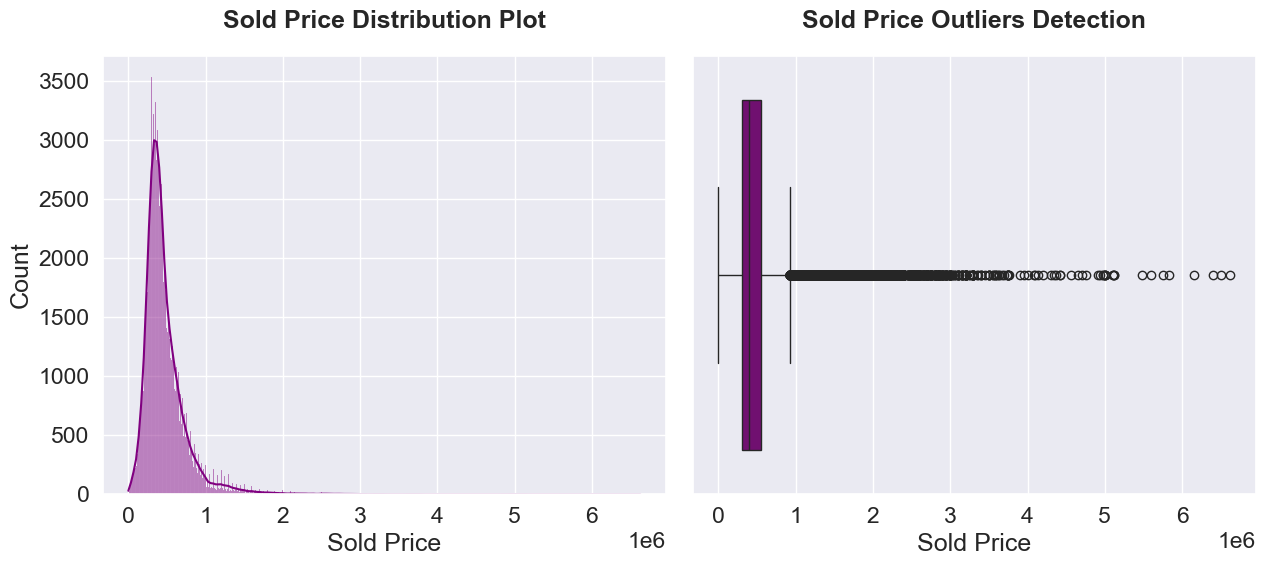

In [3]:
plt.figure(figsize=(13,6))

plt.subplot(1,2,1)
sns.histplot(df["Sold Price"],color="purple",kde=True)
plt.title("Sold Price Distribution Plot",fontweight="black",pad=20,size=18)

plt.subplot(1,2,2)
sns.boxplot(df["Sold Price"],color="purple", orient="h")
plt.title("Sold Price Outliers Detection",fontweight="black",pad=20,size=18)
plt.tight_layout()
plt.show()

3.Visualizing Distribution of Continous Numerical Features

The graphs above show the target feature as having a right-skewed distribution most likely due to presence of positive outliers.

In [4]:
features = ['SqFt', 'Total Baths', 'Bedrooms', 'Year Built', 'Acres', 'Zip', 'Lat', 'Lon', 'Days on Market', 'Over Asking'] # Dropping List Price as it is a direct predictor of Sold Price


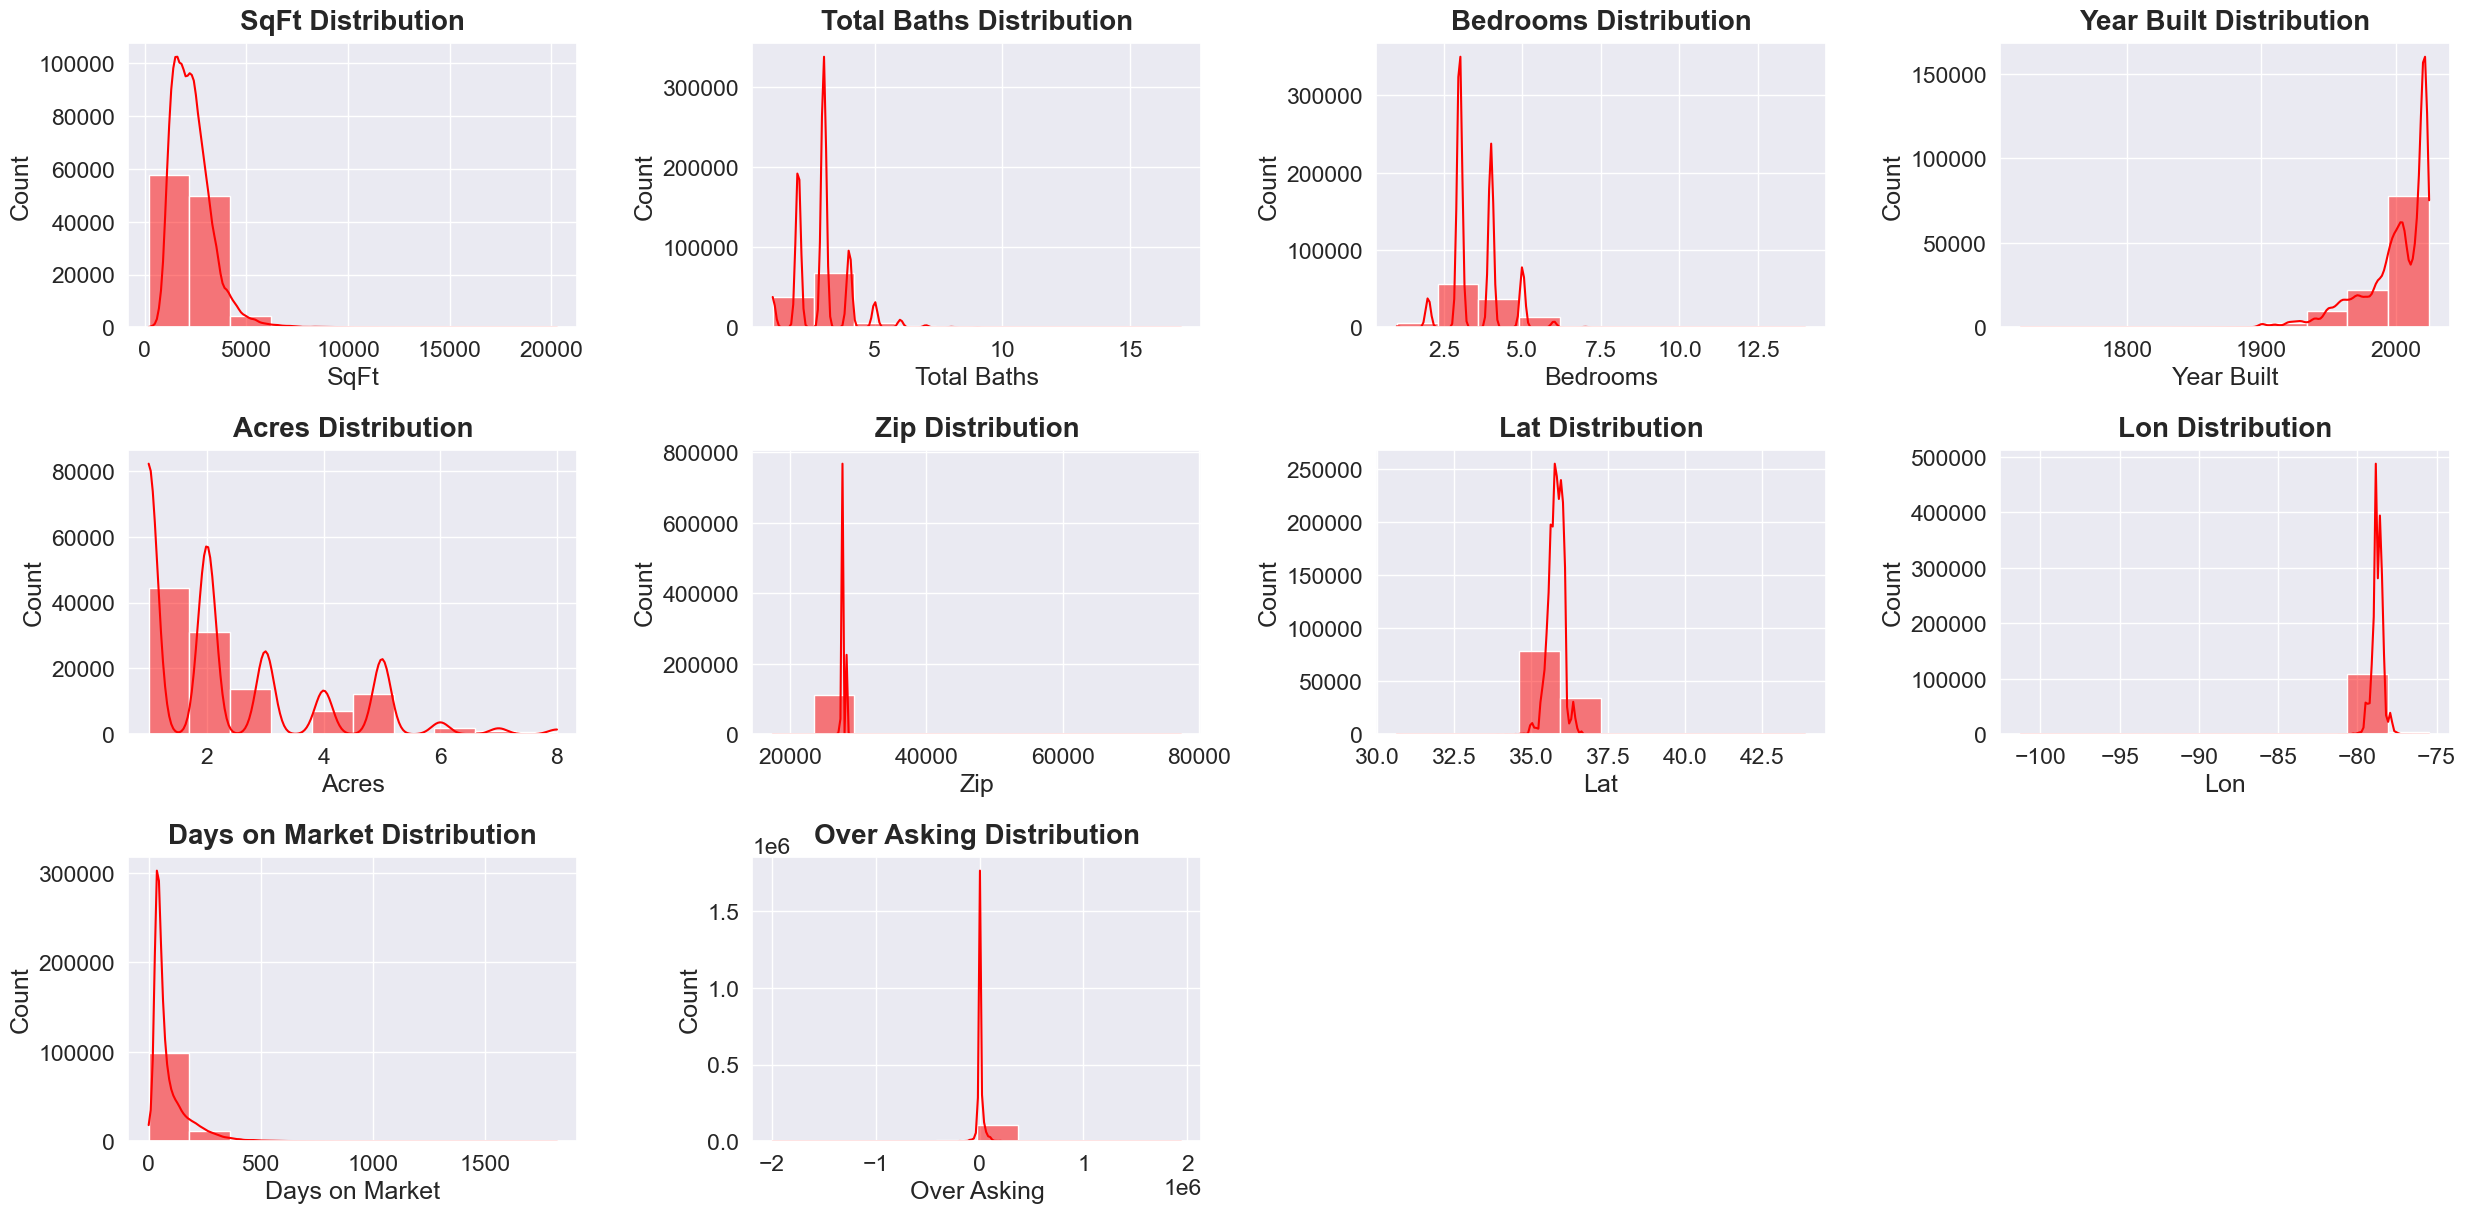

In [5]:
plt.figure(figsize=(25,20))
for index,column in enumerate(features):
    plt.subplot(5,4,index+1)
    sns.histplot(df[column],bins=10,kde=True,color="red")
    plt.title(f"{column} Distribution",fontweight="black",size=20,pad=10)
    plt.tight_layout()

In [6]:
features = ['Sold Price', 'SqFt', 'Total Baths', 'Bedrooms', 'Year Built', 'Acres', 'Zip', 'Lat', 'Lon', 'Days on Market', 'Over Asking'] # Dropping List Price as it is a direct predictor of Sold Price


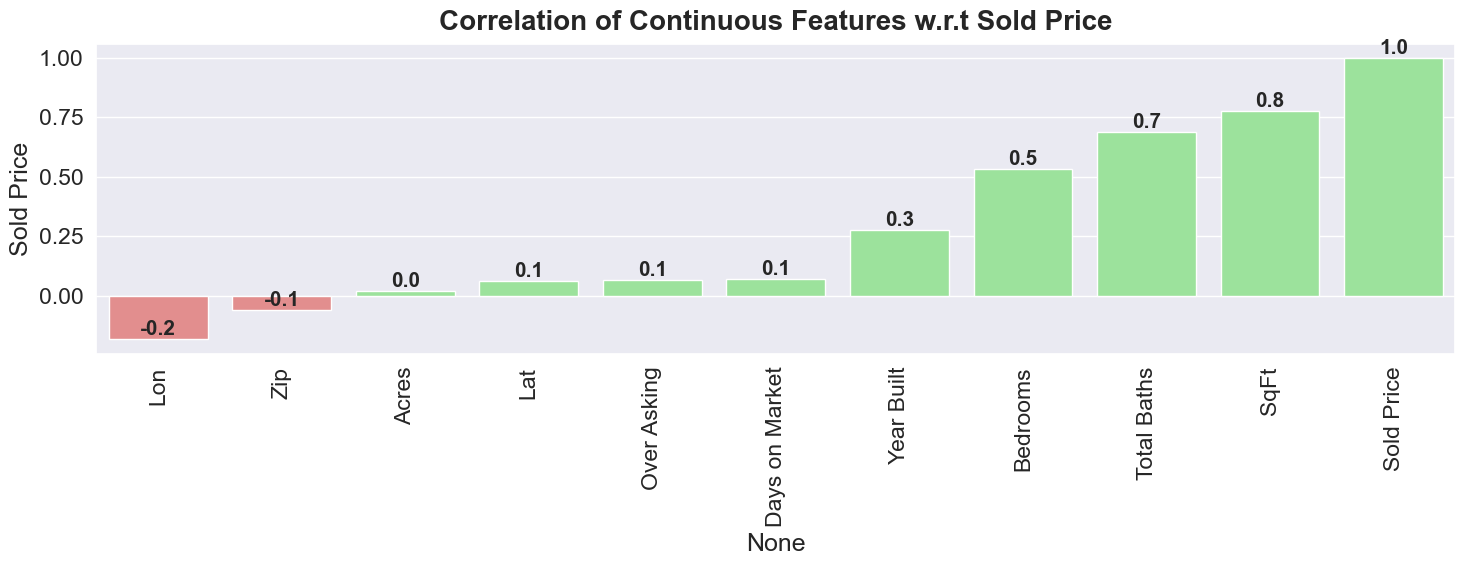

In [7]:
corr = df[features].corr(method="spearman")["Sold Price"].sort_values()

plt.figure(figsize=(15,6))
sns.barplot(x=corr.index, y=corr, palette=["lightcoral" if v < 0 else "lightgreen" for v in corr])
for i, v in enumerate(corr):
    plt.text(i, v, f"{v:.1f}", ha="center", va="bottom", size=15, fontweight="black")

plt.title("Correlation of Continuous Features w.r.t Sold Price", fontweight="black", size=20, pad=10)
plt.xticks(rotation=90)
plt.tight_layout()

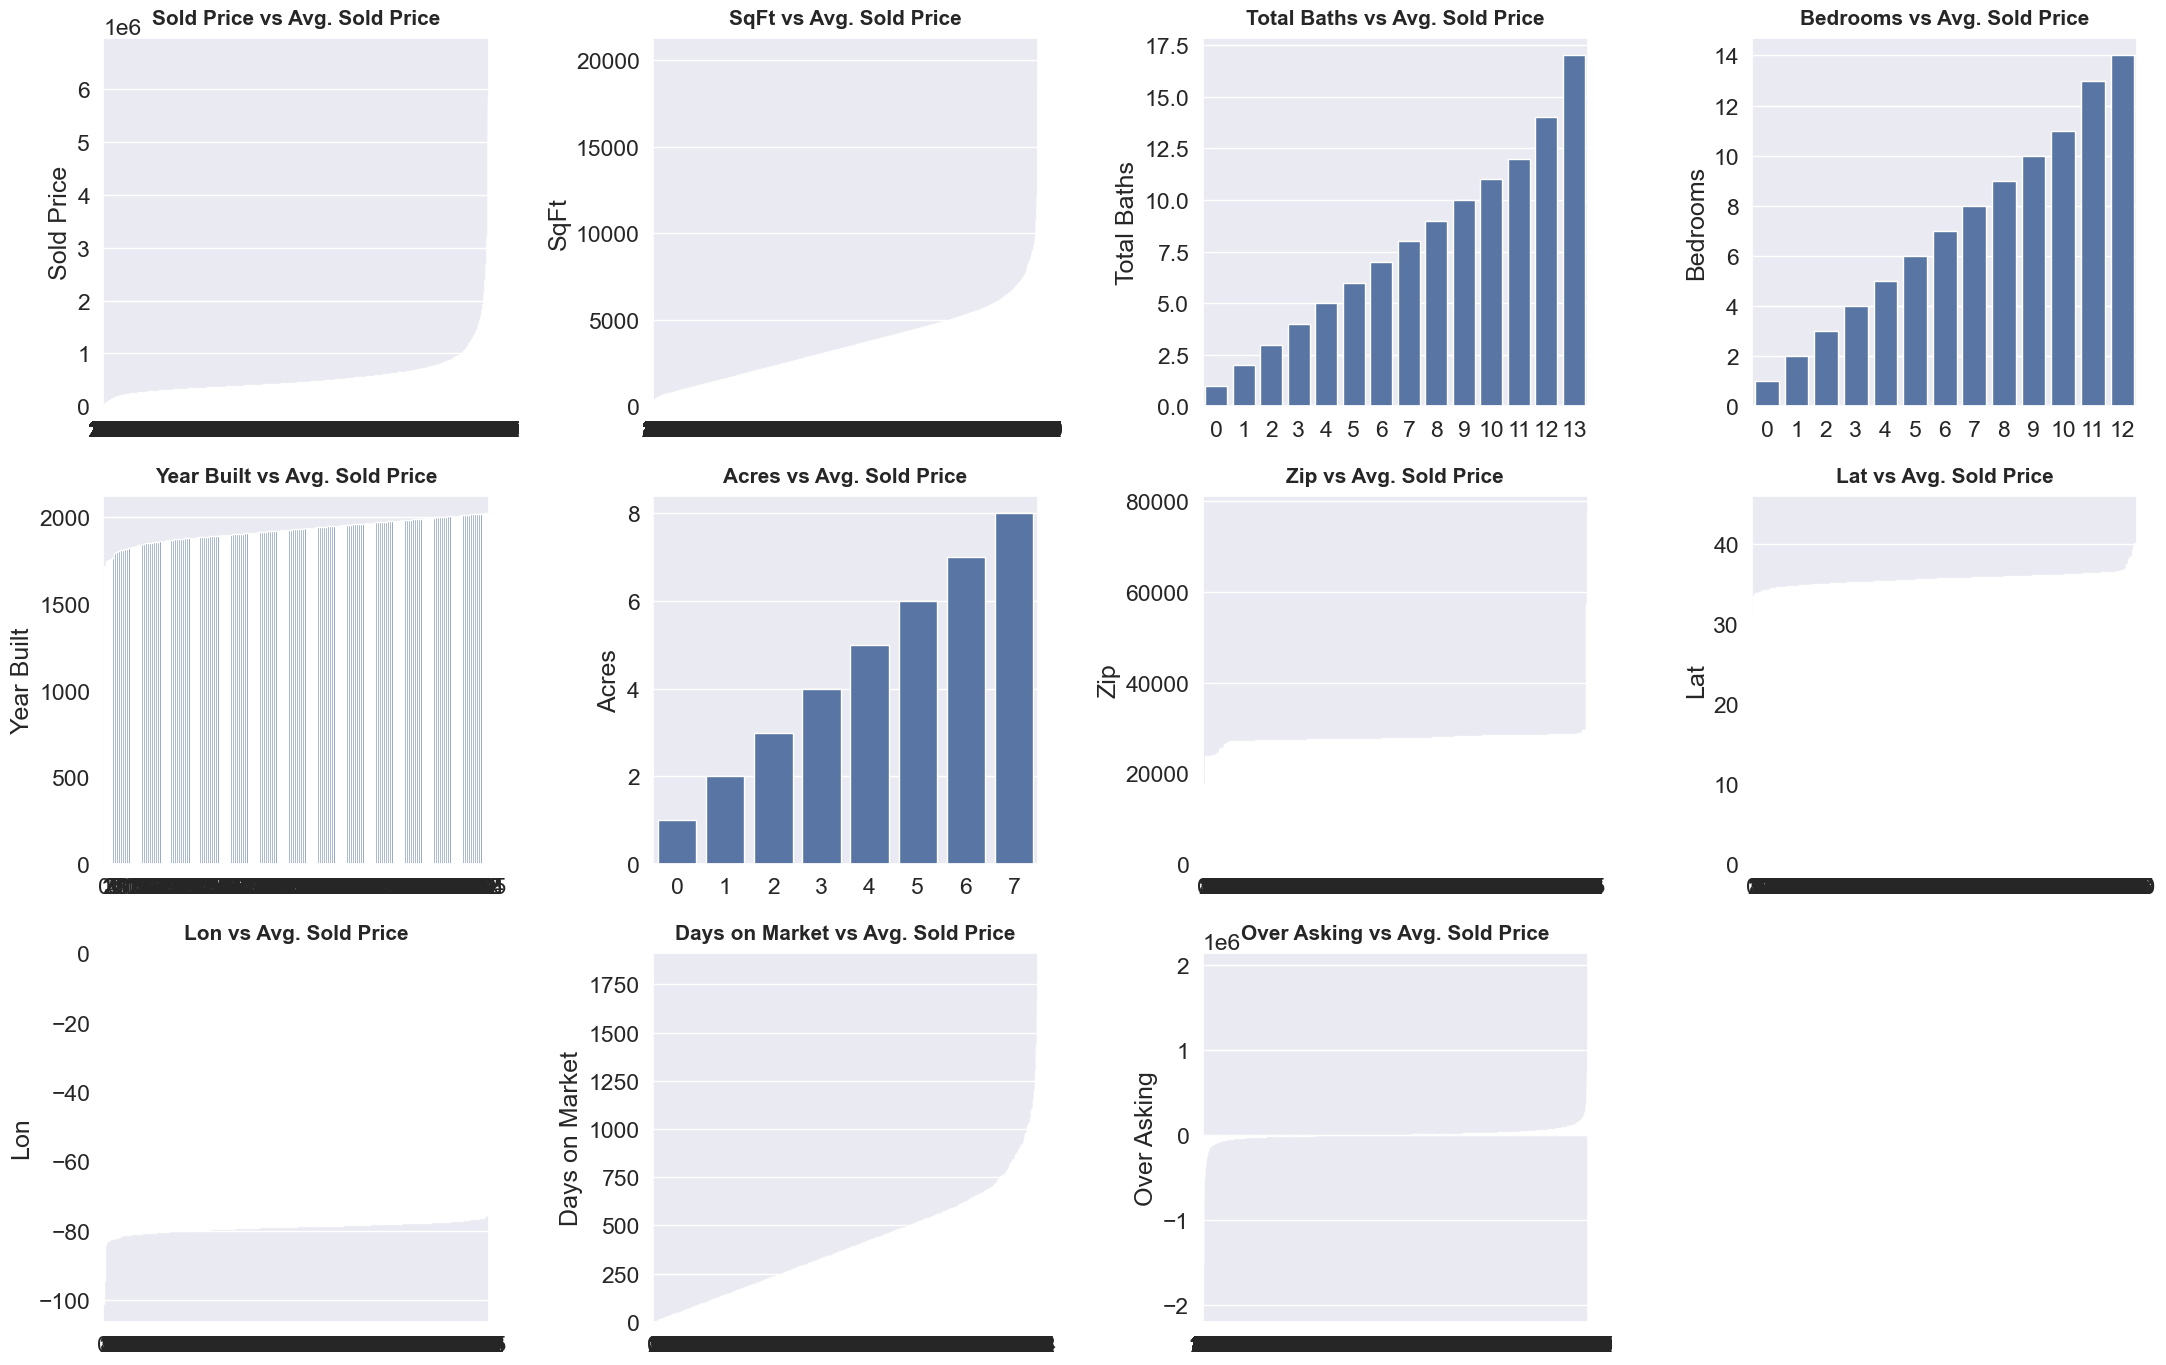

In [9]:
plt.figure(figsize=(22,14))
for index,column in enumerate(features):
    data = df.groupby(column)["Sold Price"].mean()
    plt.subplot(3,4,index+1)
    sns.barplot(data.index)
    plt.title(f"{column} vs Avg. Sold Price",fontweight="black",size=15,pad=10)
    plt.tight_layout()

In [12]:
#Calculate the Price per SqFt
df["Price per SqFt"] = df["Sold Price"]/df["SqFt"]
df.head()

,MLS #,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,List Price,Sold Price,Days on Market,Over Asking,Lat,Lon,Cluster,Price per SqFt
0,2372641,Raleigh,27607,5,8,9376,2,2022,2021-03-16,2022-02-23,1850000,324999,344,-1525001,35.8014,-78.6877,3,34.662863
1,2410217,Whitsett,27377,5,7,6983,8,1883,2021-09-27,2023-01-09,1300000,3240000,469,1940000,36.0330,-79.5972,0,463.983961
2,2375877,Wake Forest,27587,5,5,7200,7,2005,2021-04-05,2021-05-27,1800000,2900000,52,1100000,35.9815,-78.5392,2,402.777778
3,2378933,Raleigh,27615,5,7,6289,3,2022,2021-04-20,2022-09-28,2550000,3577591,526,1027591,35.8887,-78.6393,2,568.864843
4,2495996,Apex,27502,4,6,7266,5,2023,2023-02-21,2023-11-21,1755900,2598548,273,842648,35.7225,-78.8408,3,357.631159
